In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df_store = pd.read_csv('stores.csv')
df_feature = pd.read_csv('features.csv', parse_dates=[1])
df_train = pd.read_csv('train.csv', parse_dates=[2])
df_test = pd.read_csv('test.csv', parse_dates=[2])

## Data Preprocessing

In [3]:
# missing data
df_feature.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'], axis=1, inplace=True)
df_feature['CPI'].ffill(inplace=True)
df_feature['Unemployment'].ffill(inplace=True) 

In [4]:
df_feature_train = df_feature[df_feature['Date'].between('2010-02-05', '2012-10-26')]
df_train_group = df_train.groupby(['Store', 'Date']).mean()[['Weekly_Sales', 'IsHoliday']]
df_train_group.reset_index(inplace=True)
train = df_train_group.merge(df_feature_train, on=['Store', 'Date'])
df = train.groupby('Date').mean().drop('Store', axis=1).reset_index()

In [5]:
ts = df[['Date','Weekly_Sales']]
ts.columns = ["ds","y"]
ts2 = ts.set_index(keys='ds')
ts2.head()

,y
ds,
2010-02-05,16209.922128
2010-02-12,15794.946081
2010-02-19,15645.953012
2010-02-26,14397.682819
2010-03-05,15376.871198


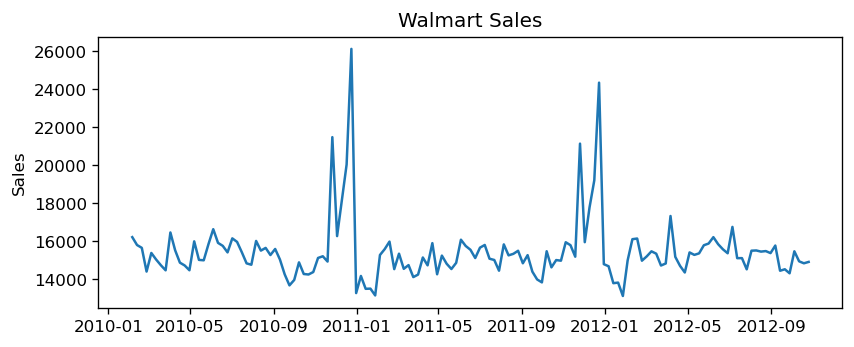

In [124]:
plt.figure(figsize=(8,3))
plt.plot(ts2)
plt.ylabel('Sales')
plt.title('Walmart Sales')
#plt.legend()
plt.show()

## Data Exploration

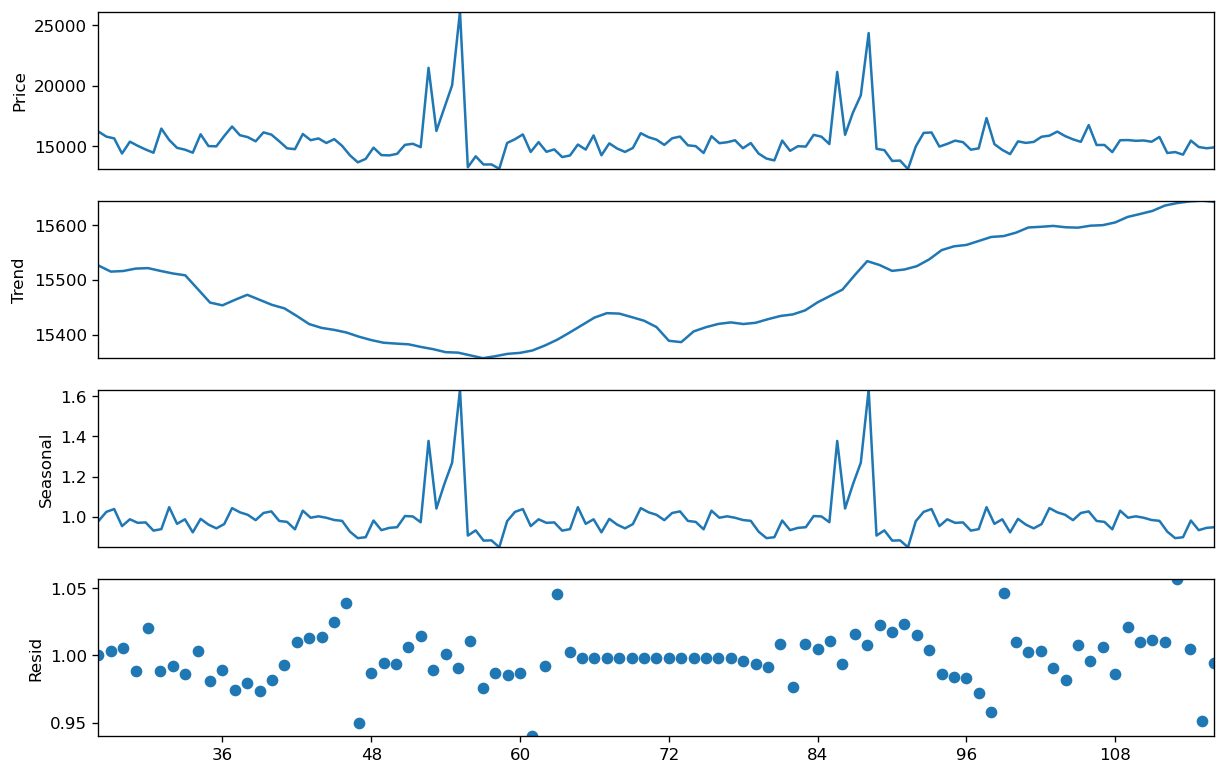

In [126]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts2, model='multiplicative', period=52)
plt.figure(figsize=(12,8))
plt.subplot(4,1,1)
plt.plot(result.observed)
plt.ylabel('Price')
plt.xticks(df.index[::12], rotation=0) #調整x軸刻度的呈現(每隔12個)
plt.margins(0)
plt.subplot(4,1,2)
plt.plot(result.trend)
plt.ylabel('Trend')
plt.xticks(df.index[::12], rotation=0)
plt.margins(0)
plt.subplot(4,1,3)
plt.plot(result.seasonal)
plt.ylabel('Seasonal')
plt.xticks(df.index[::12], rotation=0)
plt.margins(0)
plt.subplot(4,1,4)
plt.scatter(df.index,result.resid);
plt.ylabel('Resid')
plt.xticks(df.index[::12], rotation=0)
plt.margins(0)  #拆成四個subplot以利調整圖片間距、x軸刻度的呈現

In [8]:
# 平穩性檢驗 stationary
# ADF檢驗的零假設是時間序列是非平穩的。因此，如果檢驗的p值小於顯著性水平（0.05），則拒絕原假設，並推斷時間序列確實是平穩的。

#因此，在我們的情況下，如果P值> 0.05，我們將繼續尋找差分的階數。
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(ts2.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -5.917227
p-value: 0.000000


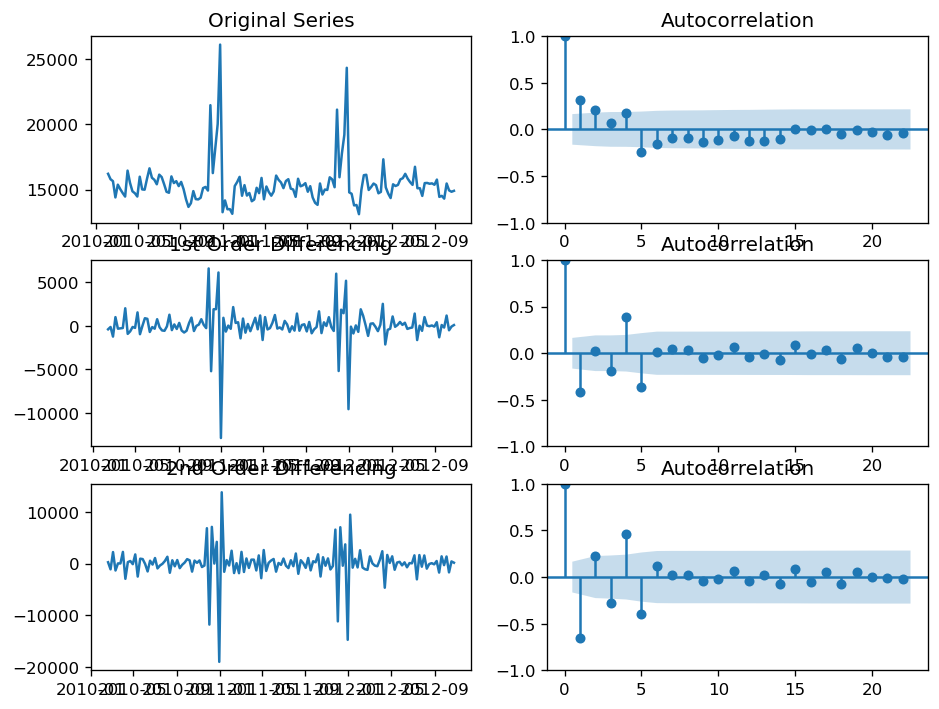

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#plt.figure(figsize=(18,12))
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
fig, axs = plt.subplots(3, 2)

#原始資料
axs[0, 0].plot(ts2)
axs[0, 0].set_title('Original Series')
plot_acf(ts2, ax=axs[0, 1])

# 一階差分
axs[1, 0].plot(ts2.diff())
axs[1, 0].set_title('1st Order Differencing')
plot_acf(ts2.diff().dropna(), ax=axs[1, 1])

# 二階差分
axs[2, 0].plot(ts2.diff().diff())
axs[2, 0].set_title('2nd Order Differencing')
plot_acf(ts2.diff().diff().dropna(), ax=axs[2, 1])

plt.show()

## Train Test Split

In [10]:
train = ts2[:114]
test = ts2[114:]

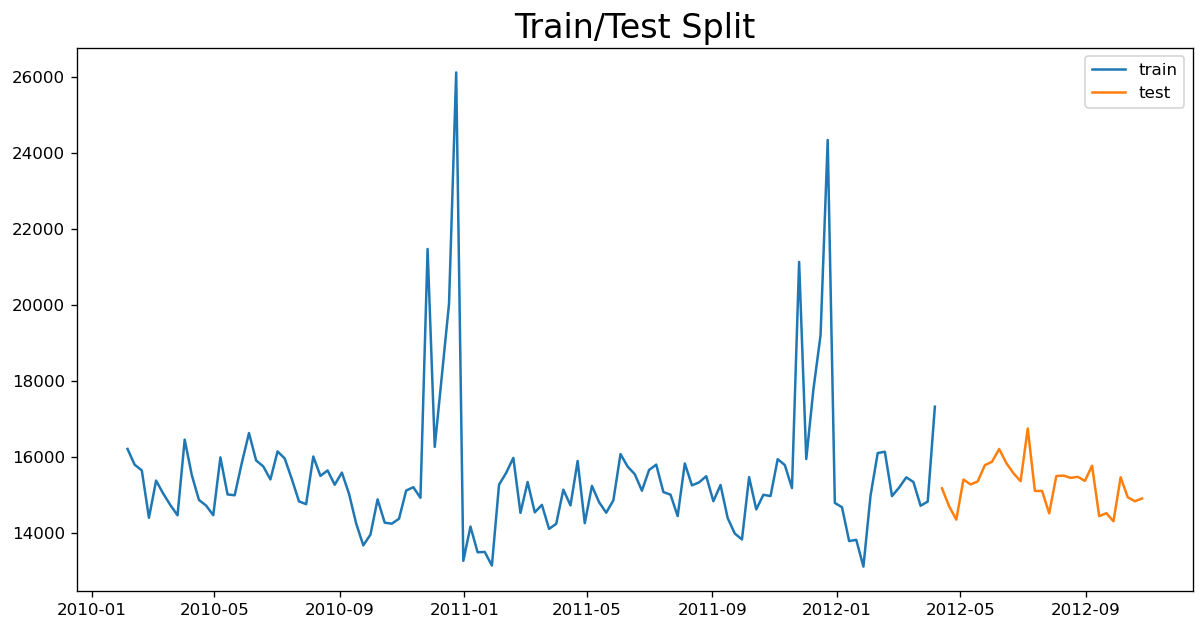

In [11]:
plt.figure(figsize=(12,6))
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.legend()
plt.title('Train/Test Split', fontsize=20)
plt.show()

## Model

In [12]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [13]:
def sarima(train, test, order, seasonal_order):
    model = sm.tsa.statespace.SARIMAX(train, order=(1, 1, 1), seasonal_order=(2, 1, 3, 52))
    model_fit = model.fit(disp=False) 
    fcast_len = len(test)
    fcast = model_fit.forecast(fcast_len)
    mse = mean_squared_error(test, fcast)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test, fcast)
    
    results = {}
    results['predictions'] = fcast
    results['mse'] = mse
    results['rmse'] = rmse
    results['mae'] = mae
    return results

In [14]:
sarima_fcast = sarima(train, test, (1, 1, 1), (1, 0, 0, 52))
mse = sarima_fcast['mse']
rmse = sarima_fcast['rmse']
mae = sarima_fcast['mae']
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')

/Users/vivianho/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  warnings.warn('No frequency information was'
/Users/vivianho/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  warnings.warn('No frequency information was'
/Users/vivianho/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/vivianho/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihoo

Mean Squared Error: 429284.3602534614
Root Mean Squared Error: 655.1979550131864
Mean Absolute Error: 559.2800939723245


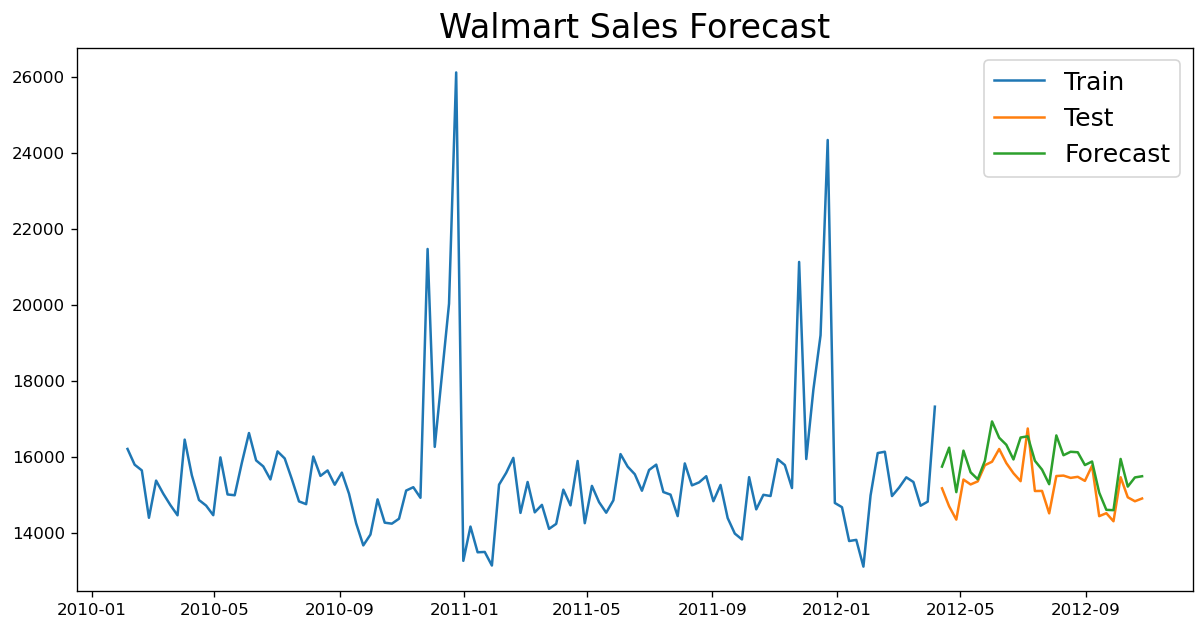

In [15]:
pd.plotting.register_matplotlib_converters()
plt.figure(figsize=(12, 6))
plt.title('Walmart Sales Forecast', fontsize=20)
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(sarima_fcast['predictions'], label='Forecast')
plt.legend(fontsize=15)
plt.show()

## Rolling Forecasting

In [16]:
def rolling_forecast(train, test, order, season):
    history = [x for x in train['y'].values]
    model = sm.tsa.statespace.SARIMAX(history, order= order, seasonal_order= season)
    model_fit = model.fit(disp=False)
    predictions = []
    results = {}
    yhat = model_fit.forecast()[0]

    predictions.append(yhat)
    history.append(test['y'][0])
    for i in range(1, len(test)):
        model = sm.tsa.statespace.SARIMAX(history, order= order, seasonal_order= season)
        model_fit = model.fit(disp=False)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test['y'][i])
    mse = mean_squared_error(test, predictions)
    mae = mean_absolute_error(test, predictions)
    rmse = np.sqrt(mse)
    predictions = pd.Series(predictions, index=test.index)
    results['predictions'] = predictions
    results['mse'] = mse
    results['rmse'] = rmse
    results['mae'] = mae
    return results

In [17]:
rolling_fcast = rolling_forecast(train, test, (1, 1, 1), (1, 0, 0, 52))

/Users/vivianho/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/vivianho/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [18]:
mse = rolling_fcast['mse']
rmse = rolling_fcast['rmse']
mae = rolling_fcast['mae']
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 193448.18600930672
Root Mean Squared Error: 439.82745026806447
Mean Absolute Error: 340.15954428352575


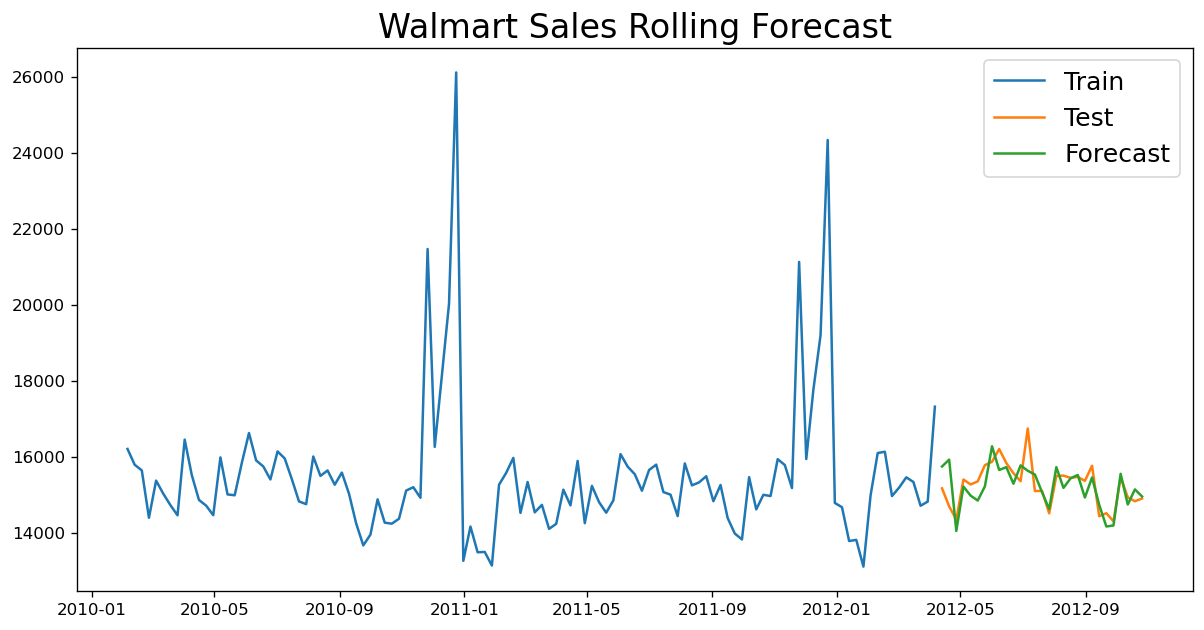

In [19]:
pd.plotting.register_matplotlib_converters()
plt.figure(figsize=(12, 6))
plt.title('Walmart Sales Rolling Forecast', fontsize=20)
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(rolling_fcast['predictions'], label='Forecast')
plt.legend(fontsize=15)
plt.show()

## Hyperparameter Tuning

In [20]:
import itertools

In [21]:
param_grid_order = {  
    'p': [0, 1],
    'd': [0],
    'q': [0, 1]}
all_params_order = [dict(zip(param_grid_order.keys(), v)) for v in itertools.product(*param_grid_order.values())]

param_grid_season = {  
    'P': [0, 1, 2],
    'D': [0],
    'Q': [0],
    's': [52]}
all_params_season = [dict(zip(param_grid_season.keys(), v)) for v in itertools.product(*param_grid_season.values())]

In [22]:
all_params_order2=[]
for i in all_params_order:
    all_params_order2.append([i['p'], i['d'],i['q']])
    
all_params_season2=[]
for i in all_params_season:
    all_params_season2.append([i['P'], i['D'],i['Q'],i['s']])

In [23]:
model = sm.tsa.statespace.SARIMAX(train, order=(0,0,1), seasonal_order=(1,0,0,52))
model_fit = model.fit(disp=False) 
fcast_len = len(test)
fcast = model_fit.forecast(fcast_len)
mse = mean_squared_error(test, fcast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, fcast)
aic = model_fit.aic
results = {}
results['predictions'] = fcast
results['mse'] = mse
results['rmse'] = rmse
results['mae'] = mae
results['aic'] = aic   

/Users/vivianho/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  warnings.warn('No frequency information was'
/Users/vivianho/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  warnings.warn('No frequency information was'


In [24]:
def hyper_sarima(train, test, order, season):
    model = sm.tsa.statespace.SARIMAX(train, order=order, seasonal_order=season)
    model_fit = model.fit(disp=False) 
    fcast_len = len(test)
    fcast = model_fit.forecast(fcast_len)
    mse = mean_squared_error(test, fcast)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test, fcast)
    aic = model_fit.aic
    results = {}
    results['predictions'] = fcast
    results['mse'] = mse
    results['rmse'] = rmse
    results['mae'] = mae
    results['aic'] = aic
    return results

In [25]:
import warnings

In [26]:
result_saved = []
warnings.filterwarnings("ignore")
for i in all_params_order2:
    for j in all_params_season2:
        result = hyper_sarima(train, test, i, j)
        result_saved.append([i, j, result['mse'], result['rmse'], result['mae'], result['aic']])

tuning_results = pd.DataFrame(result_saved)

In [27]:
tuning_results.columns = ['order','seasonal_order','mse','rmse','mae','aic']
tuning_results.sort_values('rmse')

,order,seasonal_order,mse,rmse,mae,aic
2,"[0, 0, 0]","[2, 0, 0, 52]",1.732691e+05,416.256073,332.310348,2140.501756
10,"[1, 0, 1]","[1, 0, 0, 52]",1.969071e+05,443.742110,328.508631,1933.524324
1,"[0, 0, 0]","[1, 0, 0, 52]",2.253000e+05,474.657770,364.442074,2140.242778
4,"[0, 0, 1]","[1, 0, 0, 52]",2.375912e+05,487.433229,378.983351,2103.108457
9,"[1, 0, 1]","[0, 0, 0, 52]",4.029501e+05,634.783545,491.477168,2052.896826
11,"[1, 0, 1]","[2, 0, 0, 52]",5.770158e+05,759.615592,643.153194,1928.811358
6,"[1, 0, 0]","[0, 0, 0, 52]",1.329714e+06,1153.132229,930.992316,2081.731027
7,"[1, 0, 0]","[1, 0, 0, 52]",1.334949e+06,1155.400019,959.993332,1955.682823
8,"[1, 0, 0]","[2, 0, 0, 52]",1.389366e+06,1178.713903,942.325893,1955.952225
5,"[0, 0, 1]","[2, 0, 0, 52]",9.746452e+07,9872.412304,9803.879042,2451.074383


## Final Model

In [121]:
# With parameter order=(0,0,0) and seasonal_order=(2,0,0,52), the model gets the best result

In [118]:
model = sm.tsa.statespace.SARIMAX(train, order=(0,0,0), seasonal_order=(2,0,0,52))
model_fit = model.fit(disp=False) 
fcast_len = len(test)
fcast = model_fit.forecast(fcast_len)

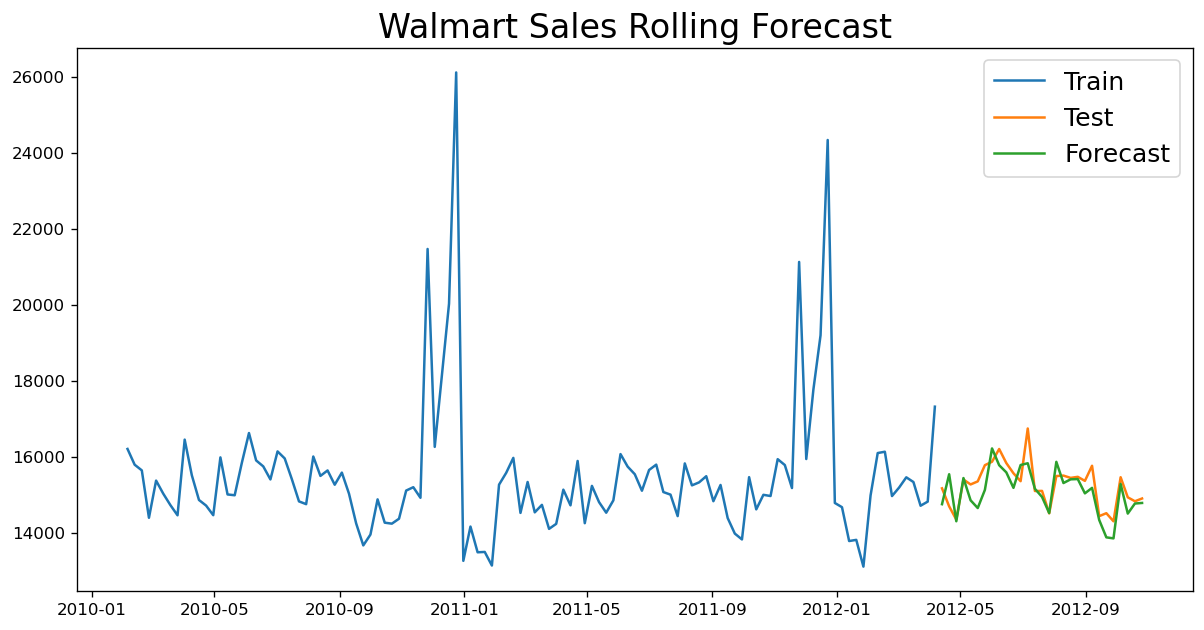

In [119]:
pd.plotting.register_matplotlib_converters()
plt.figure(figsize=(12, 6))
plt.title('Walmart Sales Rolling Forecast', fontsize=20)
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(fcast, label='Forecast')
plt.legend(fontsize=15)
plt.show()

<AxesSubplot:title={'center':'Density'}, xlabel='residual', ylabel='Density'>

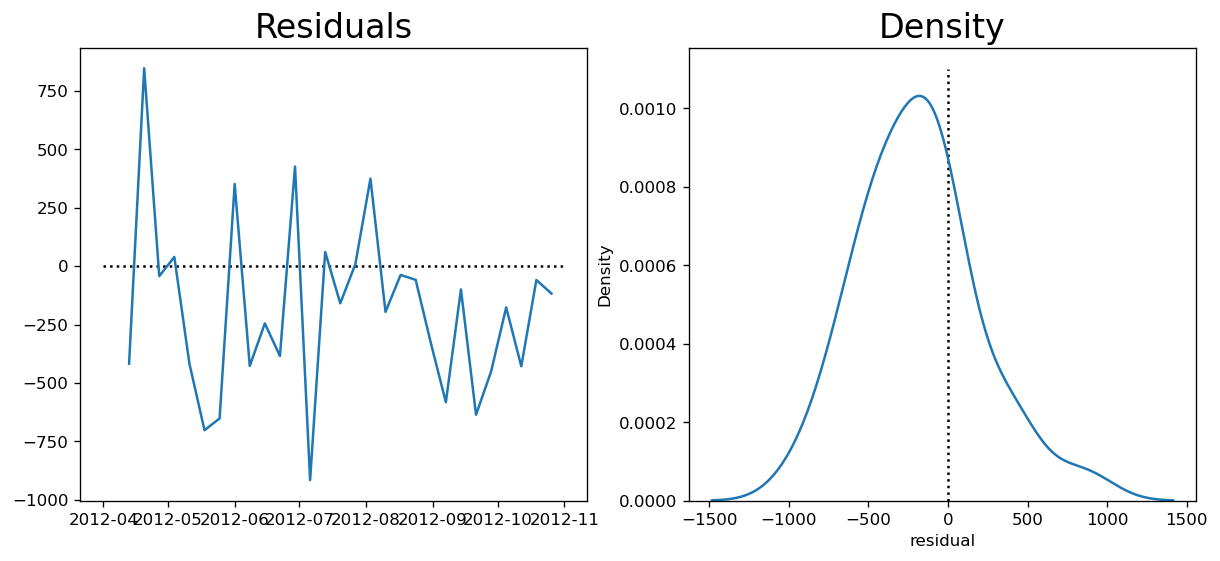

In [120]:
residual = pd.concat([fcast_pd['predicted_mean'], test['y']], axis=1)
residual['residual'] = residual['predicted_mean']-residual['y']

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Residuals', fontsize=20)
plt.plot(residual['residual'])
plt.hlines(0,'2012-04','2012-11', color='black', linestyles='dotted')
plt.subplot(1,2,2)
plt.title('Density', fontsize=20)
plt.vlines(0,0,0.0011, color='black', linestyles='dotted')
sns.kdeplot(residual['residual'], bw=0.5)